In [2]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

from experiment import solve_value_function, solve_alternative_ME
from model import ode_y, ode_y_jump_approach_one_boundary, uncertainty_decomposition
from simulation import simulation
from utilities import find_nearest_value
from numba import njit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

## Figure 9

In [4]:
ξ_w = .3
ξ_p = .3
ξ_a = 10000.

n_model = 40
damage_setting={'γ_2p': np.linspace(0, 1./3, n_model),
                'πd_o': np.ones(n_model)/n_model}

ϵ = 5.
η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)

σ_y = 1.2*np.mean(θ)
y_bar = 2.
γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = damage_setting['γ_2p']
πd_o = damage_setting['πd_o']

y_step = .04
y_grid_long = np.arange(0., 4., y_step)
y_grid_short = np.arange(0., 2+y_step, y_step)
n_bar = find_nearest_value(y_grid_long, y_bar) + 1

# Uncertainty decomposition
n_temp = 16
n_carb = 9
θ_reshape = θ.reshape(n_temp, n_carb)
θ_temp = np.mean(θ_reshape, axis=1)
θ_carb = np.mean(θ_reshape, axis=0)
πc_o_temp = np.ones_like(θ_temp)/len(θ_temp)
πc_o_carb = np.ones_like(θ_carb)/len(θ_carb)

# Prepare ϕ_i (carbon + temperature)
ϕ_list = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p_i, y_bar) 
    model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=ϵ,
                       tol=1e-8, max_iter=5_000, print_all=False)
    ϕ_list.append(model_res['v0'])

ϕ_list_short = []
for ϕ_i in ϕ_list:
    temp = ϕ_i[:n_bar]
    ϕ_list_short.append(temp)
ϕ_i_carb_temp = np.array(ϕ_list_short)

# Prepare ϕ_i (carbon)
ϕ_list = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ_carb, πc_o_carb, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p_i, y_bar) 
    model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=ϵ,
                       tol=1e-8, max_iter=5_000, print_all=False)
    ϕ_list.append(model_res['v0'])

ϕ_list_short = []
for ϕ_i in ϕ_list:
    temp = ϕ_i[:n_bar]
    ϕ_list_short.append(temp)
ϕ_i_carb = np.array(ϕ_list_short)

# Prepare ϕ_i (temperature)
ϕ_list = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ_temp, πc_o_temp, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p_i, y_bar) 
    model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=ϵ,
                       tol=1e-8, max_iter=5_000, print_all=False)
    ϕ_list.append(model_res['v0'])

ϕ_list_short = []
for ϕ_i in ϕ_list:
    temp = ϕ_i[:n_bar]
    ϕ_list_short.append(temp)
ϕ_i_temp = np.array(ϕ_list_short)

# Prepare ϕ_i (baseline)
ϕ_list = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ, πc_o, σ_y, ξ_w, 1000., γ_1, γ_2, γ_2p_i, y_bar) 
    model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=ϵ,
                       tol=1e-8, max_iter=5_000, print_all=False)
    ϕ_list.append(model_res['v0'])

ϕ_list_short = []
for ϕ_i in ϕ_list:
    temp = ϕ_i[:n_bar]
    ϕ_list_short.append(temp)
ϕ_i_baseline = np.array(ϕ_list_short)

# Compute ϕ
ς = .25
model_paras = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, ς, γ_1, γ_2, y_bar, ϕ_i_carb_temp, πd_o)
model_res = ode_y_jump_approach_one_boundary(y_grid_short, model_paras, 
                                             v0=np.average(ϕ_i_carb_temp, weights=πd_o, axis=0),
                                             ϵ=ϵ, tol=1e-8, max_iter=2_000, print_all=False)

ME_total = η/model_res['e_tilde']

Converged. Total iteration 5000: LHS Error: 5.451662936373225e-06; RHS Error 0.00025874880155724034
Converged. Total iteration 5000: LHS Error: 9.656265424951016e-06; RHS Error 0.00023832327289092375
Converged. Total iteration 5000: LHS Error: 1.4065622706205261e-05; RHS Error 0.00042643938868446724
Converged. Total iteration 5000: LHS Error: 6.38384625064603e-06; RHS Error 0.000579143146504292
Converged. Total iteration 5000: LHS Error: 3.045364458387212e-07; RHS Error 0.0007045434569804207
Converged. Total iteration 5000: LHS Error: 1.2159521153076724e-06; RHS Error 0.0008052716046364275
Converged. Total iteration 5000: LHS Error: 2.0733500538661076e-07; RHS Error 0.0009099552735980718
Converged. Total iteration 5000: LHS Error: 4.74058450494752e-06; RHS Error 0.00099072498849323
Converged. Total iteration 5000: LHS Error: 9.670995750488131e-06; RHS Error 0.001072565271808934
Converged. Total iteration 5000: LHS Error: 1.0612621435956982e-05; RHS Error 0.0011481178070123152
Converged

Converged. Total iteration 5000: LHS Error: 1.3471271076070935e-05; RHS Error 0.0007003702158734568
Converged. Total iteration 5000: LHS Error: 1.6082361796065924e-06; RHS Error 0.0008106735101342175
Converged. Total iteration 576: LHS Error: 6.047415279653023e-09; RHS Error 0.0009100184648528076
Converged. Total iteration 5000: LHS Error: 2.4141179185033225e-06; RHS Error 0.0009920213810539827
Converged. Total iteration 5000: LHS Error: 2.095658111178622e-06; RHS Error 0.0010734013030386721
Converged. Total iteration 5000: LHS Error: 3.632893827942851e-06; RHS Error 0.0011496493062845073
Converged. Total iteration 316: LHS Error: 9.648066523482157e-09; RHS Error 0.0012252005699122971
Converged. Total iteration 319: LHS Error: 9.46153635439373e-09; RHS Error 0.0012925535947904757
Converged. Total iteration 318: LHS Error: 9.864912264845316e-09; RHS Error 0.0013566676909752863
Converged. Total iteration 325: LHS Error: 9.227977426640167e-09; RHS Error 0.0014190671850417731
Converged. To

In [18]:
# Solve temperature & carbon uncertainty
model_paras_new = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_carb_temp, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=None,
                                          bc=np.average(ϕ_i_carb_temp, weights=πd_o, axis=0)[-1],
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_temp_carb = model_res_new['ME']

# Solve temperature, carbon and damage uncertainty
model_paras_new = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_carb_temp, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=None,
                                          πc=None,
                                          bc=None,
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_total_check = model_res_new['ME']

# Solve temperature uncertainty
model_paras_new = (η, δ, θ_temp, πc_o_temp, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_temp, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=None,
                                          bc=np.average(ϕ_i_temp, weights=πd_o, axis=0)[-1],
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_temp = model_res_new['ME']

# Solve carbon uncertainty
model_paras_new = (η, δ, θ_carb, πc_o_carb, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_carb, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=None,
                                          bc=np.average(ϕ_i_carb, weights=πd_o, axis=0)[-1],
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_carb = model_res_new['ME']

# Solve damage uncertainty
model_paras_new = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_baseline, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=np.ones_like(model_res['πc'])/len(θ),
                                          bc=None,
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_damage = model_res_new['ME']

# Solve temperature uncertainty + damage uncertainty
model_paras_new = (η, δ, θ_temp, πc_o_temp, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_temp, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=None,
                                          bc=None,
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_temp_damage = model_res_new['ME']

# Solve carbon uncertainty + damage uncertainty
model_paras_new = (η, δ, θ_carb, πc_o_carb, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_carb, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=None,
                                          bc=None,
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_carb_damage = model_res_new['ME']


# Solve baseline
model_paras_new = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_baseline, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=np.ones_like(model_res['πc'])/len(θ),
                                          bc=np.average(ϕ_i_baseline, weights=πd_o, axis=0)[-1],
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_baseline = model_res_new['ME']

Converged. Total iteration 316: LHS Error: 7.405665591875277e-09; RHS Error 0.0007585614539855866
Converged. Total iteration 136: LHS Error: 9.179413851256867e-09; RHS Error 0.0015596824654238416
Converged. Total iteration 84: LHS Error: 9.647221865805022e-09; RHS Error 0.0006996650422957489
Converged. Total iteration 85: LHS Error: 9.822930380209982e-09; RHS Error 0.0006124896551735239
Converged. Total iteration 440: LHS Error: 8.459889100365103e-09; RHS Error 0.001382544041524554
Converged. Total iteration 10000: LHS Error: 1.7677754478029327e-07; RHS Error 0.0015080152073170018
Converged. Total iteration 174: LHS Error: 9.874218509509091e-09; RHS Error 0.0014350733160467255
Converged. Total iteration 511: LHS Error: 8.773054638311351e-09; RHS Error 0.000554238380163101


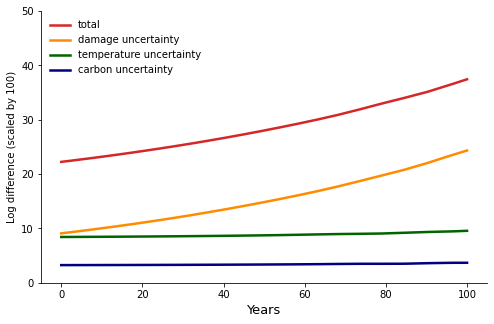

In [19]:
def simulation_me(y_grid, e_grid, ratio_grid, θ=1.86/1000., y_start=.5394, T=50):
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    ratio_t = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = np.interp(y_start, y_grid, e_grid)
        ratio_t[i] = np.interp(y_start, y_grid, ratio_grid)
        yt[i] = y_start
        y_start = y_start + Et[i]*θ
    return Et, yt, ratio_t


plt.figure(figsize=(8, 5))

_, _, total_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_total/ME_baseline)*(100), θ=np.mean(θ), y_start=1., T=100)
_, _, temp_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_temp/ME_baseline)*(100), θ=np.mean(θ), y_start=1., T=100)
_, _, carb_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_carb/ME_baseline)*(100), θ=np.mean(θ), y_start=1., T=100)
_, _, damage_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_damage/ME_baseline)*(100), θ=np.mean(θ), y_start=1., T=100)

plt.plot(total_t, label='total', color='tab:red', linewidth=2.5)
plt.plot(damage_t, label='damage uncertainty', color='darkorange', linewidth=2.5)
plt.plot(temp_t, label='temperature uncertainty', color='darkgreen', linewidth=2.5)
plt.plot(carb_t, label='carbon uncertainty', color='navy', linewidth=2.5)
plt.xlabel('Years', fontsize=13)

plt.ylabel(r'Log difference (scaled by 100)')
plt.legend(frameon=False, loc='upper left')
plt.ylim(0, 50)
plt.savefig('../plots/paper_plots/uncertainty_one_partition.pdf')

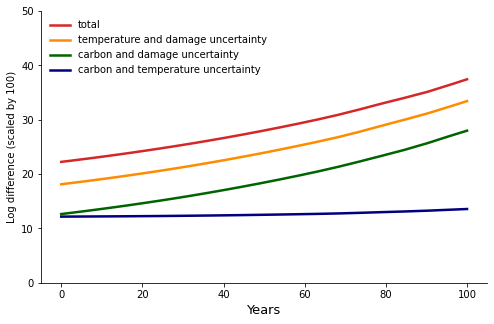

In [20]:
plt.figure(figsize=(8, 5))

_, _, total_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_total/ME_baseline)*(100), θ=np.mean(θ), y_start=1., T=100)
_, _, temp_damage_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_temp_damage/ME_baseline)*(100), θ=np.mean(θ), y_start=1., T=100)
_, _, carb_damage_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_carb_damage/ME_baseline)*(100), θ=np.mean(θ), y_start=1., T=100)
_, _, temp_carb_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_temp_carb/ME_baseline)*(100), θ=np.mean(θ), y_start=1., T=100)

plt.plot(total_t, label='total', color='tab:red', linewidth=2.5)
plt.plot(temp_damage_t, label='temperature and damage uncertainty', color='darkorange', linewidth=2.5)
plt.plot(carb_damage_t, label='carbon and damage uncertainty', color='darkgreen', linewidth=2.5)
plt.plot(temp_carb_t, label='carbon and temperature uncertainty', color='navy', linewidth=2.5)
plt.xlabel('Years', fontsize=13)

plt.ylabel(r'Log difference (scaled by 100)')
plt.legend(frameon=False, loc='upper left')
plt.ylim(0, 50)
plt.savefig('../plots/paper_plots/uncertainty_two_partition.pdf')

## Figure 10

In [ ]:
ξ_w = 100000.
ξ_p = .3
ξ_a = 1./100

ϵ = 5.
η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)

σ_y = 1.2*np.mean(θ)
y_bar = 2.
γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = damage_setting['γ_2p']
πd_o = damage_setting['πd_o']

y_step = .04
y_grid_long = np.arange(0., 4., y_step)
y_grid_short = np.arange(0., 2+y_step, y_step)
n_bar = find_nearest_value(y_grid_long, y_bar) + 1

# Uncertainty decomposition
n_temp = 16
n_carb = 9
θ_reshape = θ.reshape(n_temp, n_carb)
θ_temp = np.mean(θ_reshape, axis=1)
θ_carb = np.mean(θ_reshape, axis=0)
πc_o_temp = np.ones_like(θ_temp)/len(θ_temp)
πc_o_carb = np.ones_like(θ_carb)/len(θ_carb)

# Prepare ϕ_i (carbon + temperature)
ϕ_list = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p_i, y_bar) 
    model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=ϵ,
                       tol=1e-8, max_iter=5_000, print_all=False)
    ϕ_list.append(model_res['v0'])

ϕ_list_short = []
for ϕ_i in ϕ_list:
    temp = ϕ_i[:n_bar]
    ϕ_list_short.append(temp)
ϕ_i_carb_temp = np.array(ϕ_list_short)

# Prepare ϕ_i (carbon)
ϕ_list = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ_carb, πc_o_carb, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p_i, y_bar) 
    model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=ϵ,
                       tol=1e-8, max_iter=5_000, print_all=False)
    ϕ_list.append(model_res['v0'])

ϕ_list_short = []
for ϕ_i in ϕ_list:
    temp = ϕ_i[:n_bar]
    ϕ_list_short.append(temp)
ϕ_i_carb = np.array(ϕ_list_short)

# Prepare ϕ_i (temperature)
ϕ_list = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ_temp, πc_o_temp, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p_i, y_bar) 
    model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=ϵ,
                       tol=1e-8, max_iter=5_000, print_all=False)
    ϕ_list.append(model_res['v0'])

ϕ_list_short = []
for ϕ_i in ϕ_list:
    temp = ϕ_i[:n_bar]
    ϕ_list_short.append(temp)
ϕ_i_temp = np.array(ϕ_list_short)

# Prepare ϕ_i (baseline)
ϕ_list = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ, πc_o, σ_y, ξ_w, 1000., γ_1, γ_2, γ_2p_i, y_bar) 
    model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=ϵ,
                       tol=1e-8, max_iter=5_000, print_all=False)
    ϕ_list.append(model_res['v0'])

ϕ_list_short = []
for ϕ_i in ϕ_list:
    temp = ϕ_i[:n_bar]
    ϕ_list_short.append(temp)
ϕ_i_baseline = np.array(ϕ_list_short)

# Compute ϕ
ς = .25
model_paras = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, ς, γ_1, γ_2, y_bar, ϕ_i_carb_temp, πd_o)
model_res = ode_y_jump_approach_one_boundary(y_grid_short, model_paras, 
                                             v0=np.average(ϕ_i_carb_temp, weights=πd_o, axis=0),
                                             ϵ=ϵ, tol=1e-8, max_iter=5_000, print_all=False)

ME_total = η/model_res['e_tilde']

In [ ]:
# Solve temperature & carbon uncertainty
model_paras_new = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_carb_temp, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=None,
                                          bc=np.average(ϕ_i_carb_temp, weights=πd_o, axis=0)[-1],
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_temp_carb = model_res_new['ME']

# Solve temperature, carbon and damage uncertainty
model_paras_new = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_carb_temp, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=None,
                                          πc=None,
                                          bc=None,
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_total_check = model_res_new['ME']

# Solve temperature uncertainty
model_paras_new = (η, δ, θ_temp, πc_o_temp, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_temp, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=None,
                                          bc=np.average(ϕ_i_temp, weights=πd_o, axis=0)[-1],
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_temp = model_res_new['ME']

# Solve carbon uncertainty
model_paras_new = (η, δ, θ_carb, πc_o_carb, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_carb, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=None,
                                          bc=np.average(ϕ_i_carb, weights=πd_o, axis=0)[-1],
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_carb = model_res_new['ME']

# Solve damage uncertainty
model_paras_new = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_baseline, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=np.ones_like(model_res['πc'])/len(θ),
                                          bc=None,
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_damage = model_res_new['ME']

# Solve temperature uncertainty + damage uncertainty
model_paras_new = (η, δ, θ_temp, πc_o_temp, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_temp, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=None,
                                          bc=None,
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_temp_damage = model_res_new['ME']

# Solve carbon uncertainty + damage uncertainty
model_paras_new = (η, δ, θ_carb, πc_o_carb, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_carb, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=None,
                                          bc=None,
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_carb_damage = model_res_new['ME']


# Solve baseline
model_paras_new = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_baseline, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=np.ones_like(model_res['πc'])/len(θ),
                                          bc=np.average(ϕ_i_baseline, weights=πd_o, axis=0)[-1],
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_baseline = model_res_new['ME']

In [ ]:
def simulation_me(y_grid, e_grid, ratio_grid, θ=1.86/1000., y_start=.5394, T=50):
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    ratio_t = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = np.interp(y_start, y_grid, e_grid)
        ratio_t[i] = np.interp(y_start, y_grid, ratio_grid)
        yt[i] = y_start
        y_start = y_start + Et[i]*θ
    return Et, yt, ratio_t


plt.figure(figsize=(8, 5))

_, _, total_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_total/ME_baseline)*(100), θ=np.mean(θ), y_start=1., T=100)
_, _, temp_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_temp/ME_baseline)*(100), θ=np.mean(θ), y_start=1., T=100)
_, _, carb_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_carb/ME_baseline)*(100), θ=np.mean(θ), y_start=1., T=100)
_, _, damage_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_damage/ME_baseline)*(100), θ=np.mean(θ), y_start=1., T=100)

plt.plot(total_t, label='total', color='tab:red', linewidth=2.5)
plt.plot(damage_t, label='damage uncertainty', color='darkorange', linewidth=2.5)
plt.plot(temp_t, label='temperature uncertainty', color='darkgreen', linewidth=2.5)
plt.plot(carb_t, label='carbon uncertainty', color='navy', linewidth=2.5)
plt.xlabel('Years', fontsize=13)

plt.ylabel(r'Log difference (scaled by 100)')
plt.legend(frameon=False, loc='upper left')
plt.ylim(0, 100)
plt.savefig('../plots/paper_plots/uncertainty_one_partition_extreme.pdf')

In [ ]:
plt.figure(figsize=(8, 5))

_, _, total_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_total/ME_baseline)*(100), θ=np.mean(θ), y_start=1., T=100)
_, _, temp_damage_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_temp_damage/ME_baseline)*(100), θ=np.mean(θ), y_start=1., T=100)
_, _, carb_damage_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_carb_damage/ME_baseline)*(100), θ=np.mean(θ), y_start=1., T=100)
_, _, temp_carb_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_temp_carb/ME_baseline)*(100), θ=np.mean(θ), y_start=1., T=100)

plt.plot(total_t, label='total', color='tab:red', linewidth=2.5)
plt.plot(temp_damage_t, label='temperature and damage uncertainty', color='darkorange', linewidth=2.5)
plt.plot(carb_damage_t, label='carbon and damage uncertainty', color='darkgreen', linewidth=2.5)
plt.plot(temp_carb_t, label='carbon and temperature uncertainty', color='navy', linewidth=2.5)
plt.xlabel('Years', fontsize=13)

plt.ylabel(r'Log difference (scaled by 100)')
plt.legend(frameon=False, loc='upper left')
plt.ylim(0, 100)
plt.savefig('../plots/paper_plots/uncertainty_two_partition_extreme.pdf')